# Lesson 26: multilayer perceptron demonstration

## Notebook set up
### Imports

In [1]:
# Third party imports
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

## 1. Data preparation

### 1.1. Load California housing data

In [2]:
housing_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit2/california_housing.csv')
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
label = 'MedHouseVal'
features = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']

### 1.2. Train test split

In [5]:
training_df, testing_df = train_test_split(housing_df, random_state=42)

### 1.3. Standard scale

#### Features

In [6]:
feature_scaler = StandardScaler()
feature_scaler.fit(training_df[features])

training_df[features] = feature_scaler.transform(training_df[features])
testing_df[features] = feature_scaler.transform(testing_df[features])

#### Label

In [7]:
label_scaler = StandardScaler()
label_scaler.fit(training_df[label].to_frame())

training_df[label] = label_scaler.transform(training_df[label].to_frame())
testing_df[label] = label_scaler.transform(testing_df[label].to_frame())

### 1.4. Handle outliers

In [8]:
for feature in features:

    q1 = training_df[feature].quantile(0.25)
    q3 = training_df[feature].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    training_df[feature] = training_df[feature].clip(lower=lower_bound, upper=upper_bound)
    testing_df[feature] = testing_df[feature].clip(lower=lower_bound, upper=upper_bound)

## 2. Linear regression model

### 2.1. Fit

In [9]:
linear_model = LinearRegression(n_jobs=-1)
fit_result = linear_model.fit(training_df[features], training_df[label])

### 2.2. Test set evaluation

In [10]:
linear_predictions = linear_model.predict(testing_df[features])
linear_rsquared = linear_model.score(testing_df[features], testing_df[label])
print(f'Linear Regression R² on test set: {linear_rsquared:.4f}')

Linear Regression R² on test set: 0.6586


### 2.3. Performance analysis

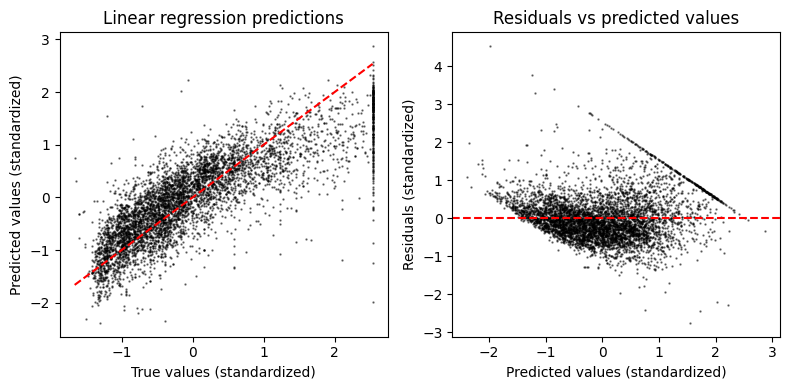

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].set_title('Linear regression predictions')
axes[0].scatter(
    testing_df[label],linear_predictions, 
    c='black', s=0.5, alpha=0.5
)
axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()], 
    color='red', linestyle='--'
)

axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    linear_predictions, testing_df[label] - linear_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()

## 3. Multilayer perceptron (MLP) model

### 3.1. Single epoch training function

In [12]:
def train(model: MLPRegressor, df: pd.DataFrame, training_history: dict) -> tuple[MLPRegressor, dict]:
    '''Trains sklearn MLP regression model on given dataframe using validation split.
    Returns the updated model and training history dictionary.'''

    global features, label

    df, val_df = train_test_split(df, random_state=315)
    model.partial_fit(df[features], df[label])

    training_history['training_rsquared'].append(model.score(df[features], df[label]))
    training_history['validation_rsquared'].append(model.score(val_df[features], val_df[label]))

    return model, training_history

### 3.2. Model training

In [13]:
epochs = 15

training_history = {
    'training_rsquared': [],
    'validation_rsquared': []
}

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    learning_rate_init=0.001,
    warm_start=True,
    random_state=315
)

for epoch in range(epochs):
    mlp_model, training_history = train(mlp_model, training_df, training_history)

    print(
        f'Epoch {epoch+1}/{epochs} - ' +
        f'training R²: {training_history["training_rsquared"][-1]:.4f} - ' +
        f'validation R²: {training_history["validation_rsquared"][-1]:.4f}'
    )

Epoch 1/15 - training R²: 0.5775 - validation R²: 0.5732
Epoch 2/15 - training R²: 0.6500 - validation R²: 0.6483
Epoch 3/15 - training R²: 0.6870 - validation R²: 0.6868
Epoch 4/15 - training R²: 0.7059 - validation R²: 0.7050
Epoch 5/15 - training R²: 0.7185 - validation R²: 0.7161
Epoch 6/15 - training R²: 0.7282 - validation R²: 0.7242
Epoch 7/15 - training R²: 0.7359 - validation R²: 0.7304
Epoch 8/15 - training R²: 0.7418 - validation R²: 0.7352
Epoch 9/15 - training R²: 0.7465 - validation R²: 0.7389
Epoch 10/15 - training R²: 0.7500 - validation R²: 0.7417
Epoch 11/15 - training R²: 0.7534 - validation R²: 0.7441
Epoch 12/15 - training R²: 0.7561 - validation R²: 0.7463
Epoch 13/15 - training R²: 0.7586 - validation R²: 0.7482
Epoch 14/15 - training R²: 0.7609 - validation R²: 0.7499
Epoch 15/15 - training R²: 0.7627 - validation R²: 0.7514


### 3.3. Learning curves

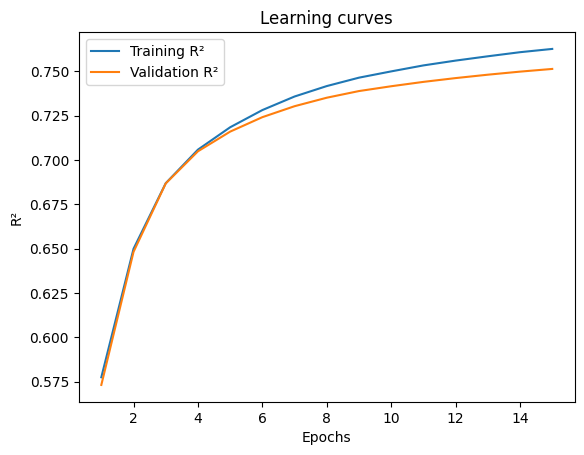

In [14]:
plt.plot(
    range(1, epochs + 1), training_history['training_rsquared'],
    label='Training R²'
)
plt.plot(
    range(1, epochs + 1), training_history['validation_rsquared'],
    label='Validation R²'
)
plt.title('Learning curves')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()
plt.show()

### 3.4. Test set evaluation

In [15]:
mlp_predictions = mlp_model.predict(testing_df[features])
mlp_rsquared = mlp_model.score(testing_df[features], testing_df[label])
print(f'MLP R² on test set: {mlp_rsquared:.4f}')

MLP R² on test set: 0.7495


### 3.5. Performance analysis

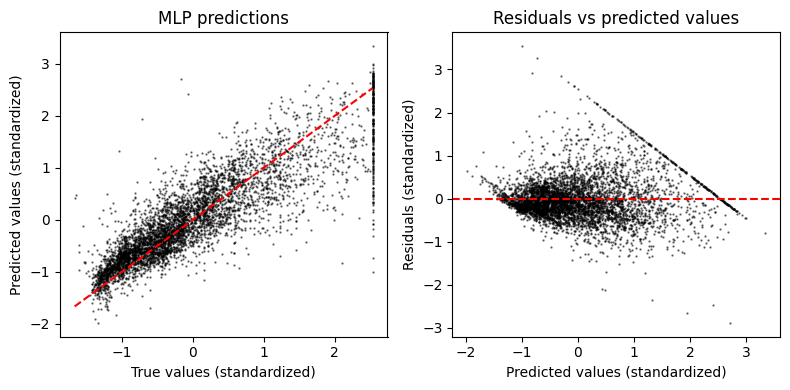

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].set_title('MLP predictions')
axes[0].scatter(
    testing_df[label], mlp_predictions, 
    c='black', s=0.5, alpha=0.5
)
axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()], 
    color='red', linestyle='--'
)

axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    mlp_predictions, testing_df[label] - mlp_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()

## 4. Model comparison

In [17]:
print(f'Linear Regression R² on test set: {linear_rsquared:.4f}')
print(f'MLP R² on test set: {mlp_rsquared:.4f}')

Linear Regression R² on test set: 0.6586
MLP R² on test set: 0.7495


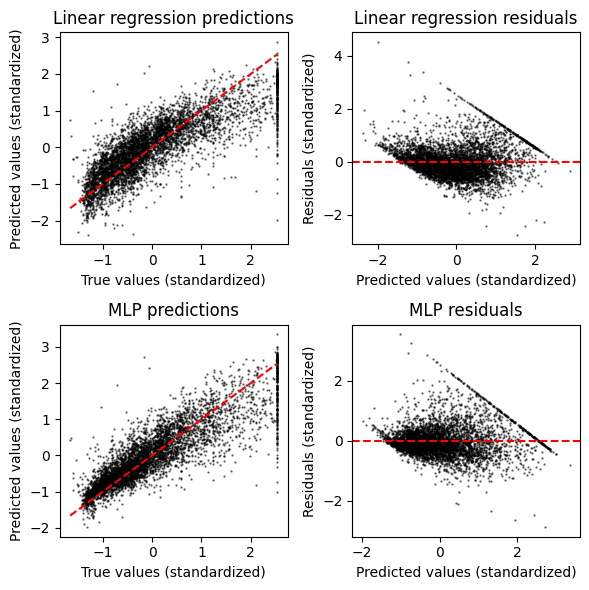

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0, 0].set_title('Linear regression predictions')
axes[0, 0].scatter(
    testing_df[label], linear_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[0, 0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)
axes[0, 0].set_xlabel('True values (standardized)')
axes[0, 0].set_ylabel('Predicted values (standardized)')

axes[0, 1].set_title('Linear regression residuals')
axes[0, 1].scatter(
    linear_predictions, testing_df[label] - linear_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted values (standardized)')
axes[0, 1].set_ylabel('Residuals (standardized)')

axes[1, 0].set_title('MLP predictions')
axes[1, 0].scatter(
    testing_df[label], mlp_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1, 0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)
axes[1, 0].set_xlabel('True values (standardized)')
axes[1, 0].set_ylabel('Predicted values (standardized)')

axes[1, 1].set_title('MLP residuals')
axes[1, 1].scatter(
    mlp_predictions, testing_df[label] - mlp_predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted values (standardized)')
axes[1, 1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()